In [1]:
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def contrastive_loss(y_true, y_pred):
    '''
    similar pairs: labeled y_true = 0, so minimizes y_pred, the Euclidean distance
    non-matching pairs: labeled y_true = 1, so maximizes the distance y_pred up to a max of margin
    '''
    margin = 1
    return K.mean((1-y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    return Model(input, x)

input_shape = (100, 3)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

base_network = create_base_network(input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(lambda x: K.abs(x[0] - x[1]))([processed_a, processed_b])

prediction = Dense(1, activation='sigmoid')(distance)

siamese_model = Model(inputs=[input_a, input_b], outputs=prediction)

siamese_model.compile(loss=contrastive_loss, optimizer='adam')

# create some matching example data (y_train = 0)
# vectors are [neg, pos, indef]
x_train_1_g = np.random.rand(500, 100, 3)*0.1
x_train_2_g = np.random.rand(500, 100, 3)*0.1
for i in range(500):
    b = np.random.randint(50)
    l = np.random.randint(30,50)
    x_train_1_g[i, b:b+l, 0] = np.random.rand(l)
    x_train_1_g[i, b+10:b + l, 1] = np.random.rand(l-10)
    b = np.random.randint(50)
    l = np.random.randint(30,50)
    x_train_2_g[i, b:b+l, 0] = np.random.rand(l)
    x_train_2_g[i, b+10:b + l, 1] = np.random.rand(l-10)
y_train_g = np.zeros((500, 1), np.float32)

# create some mismatches (y_train = 1)
x_train_1_b = x_train_1_g
x_train_2_b = np.random.rand(500, 100, 3)
x_train_2_b[:,:,2] = np.random.rand(500, 100)*0.1
y_train_b = np.ones((500, 1), np.float32)

2023-09-18 14:54:45.852642: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 14:54:45.898741: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 14:54:46.105536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 14:54:46.106588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 14:54:47.043244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# combine and shuffle the matches and mismatches and their labels
x_train_1 = np.concatenate((x_train_1_g,x_train_1_b))
x_train_2 = np.concatenate((x_train_2_g,x_train_2_b))
y_train = np.concatenate((y_train_g,y_train_b))
shuffler = np.random.permutation(1000)
x_train_1 = x_train_1[shuffler,:,:]
x_train_2 = x_train_2[shuffler,:,:]
y_train = y_train[shuffler]
print(np.shape(x_train_1), np.shape(x_train_2))
print(np.shape(y_train))

(1000, 100, 3) (1000, 100, 3)
(1000, 1)


In [3]:
# train the model
siamese_model.fit([x_train_1, x_train_2], y_train, epochs=10, batch_size=16)

Epoch 1/10
63/63 [==============================] - 1s 1ms/step - loss: 0.0696
Epoch 2/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 3/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 4/10
63/63 [==============================] - 0s 1ms/step - loss: 9.6659e-04
Epoch 5/10
63/63 [==============================] - 0s 1ms/step - loss: 4.9148e-04
Epoch 6/10
63/63 [==============================] - 0s 1ms/step - loss: 3.0480e-04
Epoch 7/10
63/63 [==============================] - 0s 1ms/step - loss: 2.0611e-04
Epoch 8/10
63/63 [==============================] - 0s 1ms/step - loss: 1.4928e-04
Epoch 9/10
63/63 [==============================] - 0s 1ms/step - loss: 1.1210e-04
Epoch 10/10
63/63 [==============================] - 0s 1ms/step - loss: 8.7408e-05


1/1 [==============================] - 0s 62ms/step


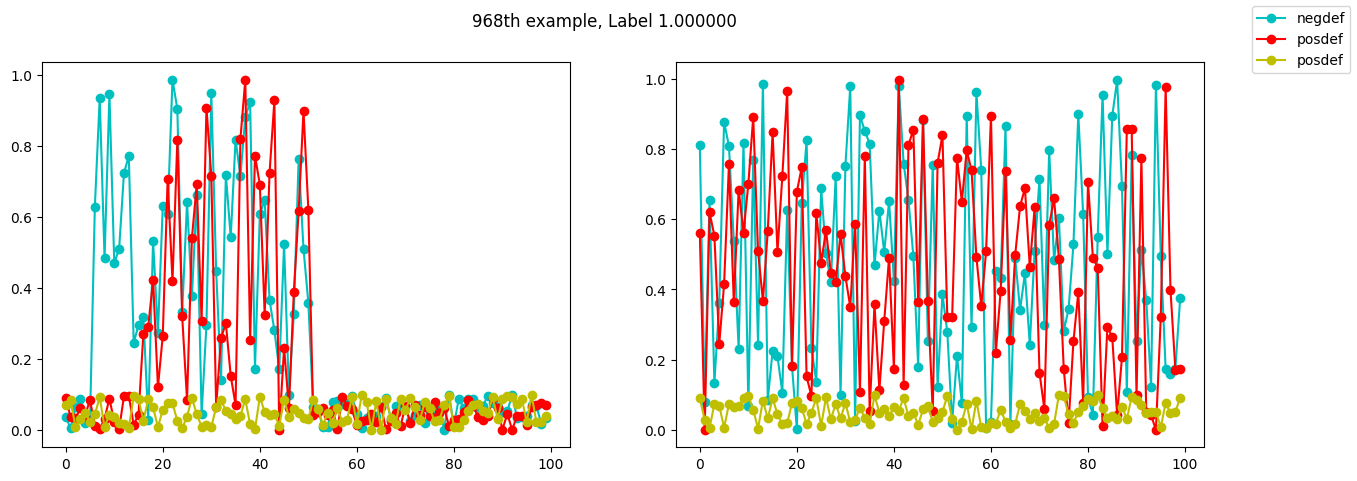

In [4]:
# plot a random training pair
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))

x = range(100)
i = np.random.randint(1000)
ax1.plot(x,x_train_1[i,:,0],'co-',label='negdef')
ax1.plot(x,x_train_1[i,:,1],'ro-',label='posdef')
ax1.plot(x,x_train_1[i,:,2],'yo-',label='posdef')
ax2.plot(x,x_train_2[i,:,0],'co-')
ax2.plot(x,x_train_2[i,:,1],'ro-')
ax2.plot(x,x_train_2[i,:,2],'yo-')  
fig.legend()

# test with train data
test_1 = np.expand_dims(x_train_1[i,:,:],0) #add the batch axis
test_2 = np.expand_dims(x_train_2[i,:,:],0) #add the batch axis
label = siamese_model.predict([test_1,test_2])

fig.suptitle('%ith example, Label %f'%(i, round(label[0,0],2)))
pass